In [1]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
# from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

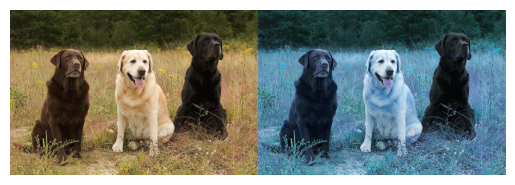

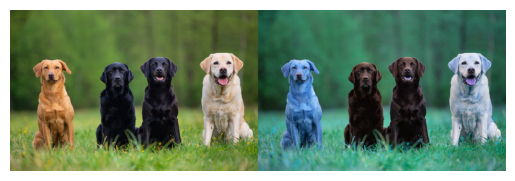

In [2]:
urls = ['https://www.akc.org/wp-content/uploads/2017/11/Labrador-Retrievers-three-colors.jpg',
        'https://www.dogbible.com/i/en/4-labrador-retriever-in-the-grass.jpeg']

for url in urls:
    image = io.imread(url)
    # io.imread(url) from the skimage library reads the image directly from the web URL and returns it as a NumPy array. 
    # This array represents the image in RGB format.
    cvt_img = cv.cvtColor(image, cv.COLOR_RGB2BGR)
    final_frame = cv.hconcat((image, cvt_img))
    
    # Display using matplotlib
    plt.imshow(final_frame)
    plt.axis('off')  # Hides the axis
    plt.show()

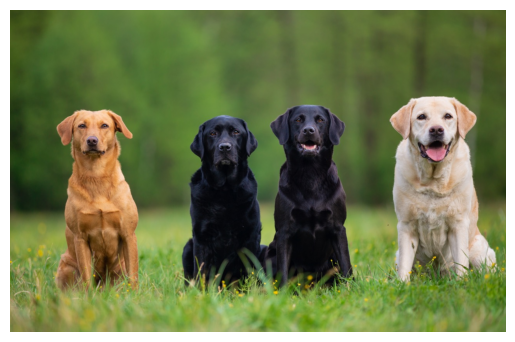

In [3]:
from urllib.request import urlopen
image_url = 'https://www.dogbible.com/i/en/4-labrador-retriever-in-the-grass.jpeg'
resp = urlopen(image_url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv.imdecode(image, cv.IMREAD_COLOR)  # Decode the image

# Convert the image from BGR (OpenCV default) to RGB for correct color display in matplotlib
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Hide axis
plt.show()

In [4]:
# Function for vertically concatenating images with different widths
def vconcat_resize(img_list, interpolation=cv.INTER_CUBIC):
    # Find the minimum width among all images in the list
    w_min = min(img.shape[1] for img in img_list)

    # Resize each image to the minimum width while keeping the aspect ratio for height
    im_list_resize = [cv.resize(img, (w_min, int(img.shape[0] * w_min / img.shape[1])),
                                interpolation=interpolation) for img in img_list]

    # Vertically concatenate all resized images
    return cv.vconcat(im_list_resize)


# Function for horizontally concatenating images with different heights
def hconcat_resize(img_list, interpolation=cv.INTER_CUBIC):
    # Find the minimum height among all images in the list
    h_min = min(img.shape[0] for img in img_list)

    # Resize each image to the minimum height while keeping the aspect ratio for width
    im_list_resize = [cv.resize(img, (int(img.shape[1] * h_min / img.shape[0]), h_min),
                                interpolation=interpolation) for img in img_list]

    # Horizontally concatenate all resized images
    return cv.hconcat(im_list_resize)


# Function to concatenate images in a 2D grid layout with resizing
def concat_tile_resize(list_2d, interpolation=cv.INTER_CUBIC):
    # Apply horizontal concatenation for each list of images (row)
    img_list_v = [hconcat_resize(list_h, interpolation=interpolation) for list_h in list_2d]

    # Vertically concatenate all rows to create the final grid
    return vconcat_resize(img_list_v, interpolation=interpolation)


# Example usage
# Suppose img1, img2, img3, img4 are images loaded with cv.imread()

# Create a 2D list of images for the grid layout (2 rows, 2 images per row)
# list_2d = [[img1, img2], [img3, img4]]

# Concatenate images into a tiled format
# tiled_image = concat_tile_resize(list_2d)

# Convert the image to RGB format for correct display in matplotlib
# tiled_image_rgb = cv.cvtColor(tiled_image, cv.COLOR_BGR2RGB)

# Display the concatenated image
# plt.imshow(tiled_image_rgb)
# plt.axis('off')  # Hide axis for a cleaner look
# plt.show()


In [5]:
from urllib.parse import urlsplit

urls = ['https://www.akc.org/wp-content/uploads/2017/11/Labrador-Retrievers-three-colors.jpg',
        'https://www.dogbible.com/i/en/4-labrador-retriever-in-the-grass.jpeg']
for image_url in urls:
    # Extract the filename from the URL
    filename = os.path.basename(urlsplit(image_url).path)

    # Open the URL and read the image data
    resp = urlopen(image_url)
    image_data = np.asarray(bytearray(resp.read()), dtype="uint8")

    # Decode the image data to OpenCV format
    image = cv.imdecode(image_data, cv.IMREAD_COLOR)

    # Save the image with the extracted filename
    cv.imwrite(filename, image)

# Traditional Image Segmentation Methods

- Basic Thresholding
- Otsu's Thresholding

## Mean Shift Thresholding

- non-parametric clustering algorithm that does not require the number of clusters in advance. Instead, it groups data points by iteratively shifting them towards areas of higher density.

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MeanShift, estimate_bandwidth

In [7]:
import os
print(os.getcwd())  # Check the current working directory
print(os.listdir())  

/home/jupyter-dsai-st123439/Segmentation
['UNET.ipynb', '4-labrador-retriever-in-the-grass.jpeg', 'Segmentation_Classical.ipynb', '.ipynb_checkpoints', 'Labrador-Retrievers-three-colors.jpg']


In [8]:
ms_img = cv.imread('./4-labrador-retriever-in-the-grass.jpeg')
ms_img = cv.cvtColor(ms_img, cv.COLOR_BGR2RGB)  # (height, width, 3)
ms_img = cv.resize(ms_img, None, fx= 0.5, fy= 0.5, interpolation= cv.INTER_LINEAR)  # Resize to half
ms_img2D = ms_img.reshape((-1,3))  # (height × width, 3)
ms_img2D = np.float32(ms_img2D)

In [9]:
ms_img2D.shape

(266240, 3)

In [10]:
# Normalization
norm_ms_img2d= MinMaxScaler(feature_range=(0, 1)).fit_transform(ms_img2D)

In [11]:
bandwidth = estimate_bandwidth(norm_ms_img2d, quantile=.04, n_jobs=2)

# calculates a suitable bandwidth parameter, which controls the size of the search window used
# A smaller quantile value means a smaller bandwidth resulting in more clusters and vice versa

In [12]:
ms_res = MeanShift(bandwidth = bandwidth, n_jobs=2, bin_seeding=True, cluster_all=True).fit(norm_ms_img2d)
# Docs: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html
# cluster_all=True ensures that all points are assigned to clusters.

### Extracting Labels and Centers:

In [13]:
# Get labels and centers of the clusters
labels = ms_res.labels_
centers = ms_res.cluster_centers_

# Reshape labels back to the original image shape, so each pixel’s cluster label corresponds to its original position in the image.
segmented_image = labels.reshape(ms_img.shape[:2])

In [14]:
centers

array([[0.35657686, 0.47784105, 0.2404781 ],
       [0.04287902, 0.04410756, 0.06641251],
       [0.5376775 , 0.67374367, 0.33006635],
       [0.8882584 , 0.8857496 , 0.86948335],
       [0.8239903 , 0.8025836 , 0.7653409 ],
       [0.6861275 , 0.6647523 , 0.6108767 ],
       [0.6257005 , 0.43646294, 0.2600433 ],
       [0.76882607, 0.55994564, 0.35200584],
       [0.5404025 , 0.5237317 , 0.4252951 ],
       [0.79549253, 0.49325407, 0.58451974],
       [0.8391807 , 0.5696322 , 0.6542133 ],
       [0.5624481 , 0.62468433, 0.7604406 ],
       [0.6459387 , 0.42731476, 0.4751901 ],
       [0.8233895 , 0.80863106, 0.25465187],
       [0.8529412 , 0.7930556 , 0.15102705],
       [0.89725494, 0.81291664, 0.06932773]], dtype=float32)

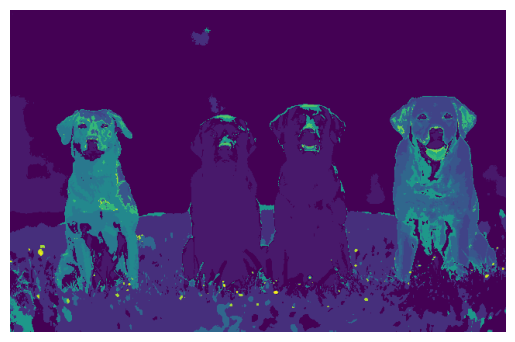

In [15]:
plt.axis('off')
plt.imshow(segmented_image)
plt.show()

## Clustering based

### k-mean

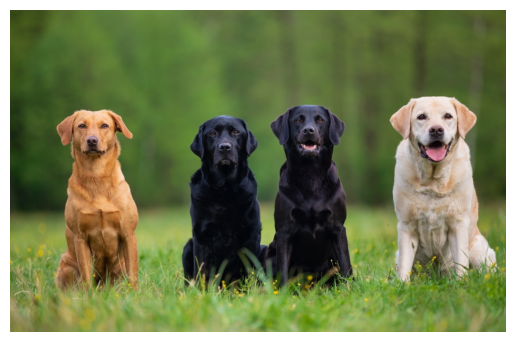

In [16]:
img_in = cv.imread('./4-labrador-retriever-in-the-grass.jpeg')
img = cv.cvtColor(img_in, cv.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(img)

In [17]:
# Reshape image from 3D to 2D vector
img2D = img.reshape((-1,3))
img2D = np.float32(img2D)

In [18]:
plt.axis('off')
plt.imshow(img2D)

**criteria** :

It is the iteration termination criteria. When this criteria is satisfied, algorithm iteration stops. Actually, it should be a tuple of 3 parameters. They are `( type, max_iter, epsilon )`:

type of termination criteria. It has 3 flags as below:
- cv.TERM_CRITERIA_EPS - stop the algorithm iteration if specified accuracy, epsilon, is reached.
- cv.TERM_CRITERIA_MAX_ITER - stop the algorithm after the specified number of iterations, max_iter.
- cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER - stop the iteration when any of the above condition is met.

`max_iter` - An integer specifying maximum number of iterations.

`epsilon` - Required accuracy

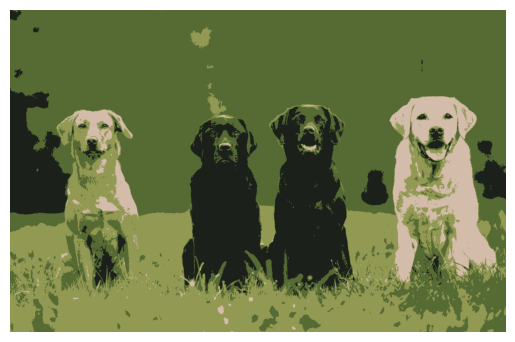

In [19]:
# Define criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# algorithm will stop either when it reaches 10 iterations or when the algorithm's accuracy is less than 1.0 (the change in cluster centers).
K = 4           # number of clusters
attemp = 10     # number of times the algorithm will be executed with different initial labellings.

ret,label,center=cv.kmeans(img2D,K,None,criteria,attemp,cv.KMEANS_PP_CENTERS)
# ret - The compactness measure 

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]  # Maps each pixel to its corresponding cluster center color
final_res = res.reshape((img.shape))

plt.axis('off')
plt.imshow(final_res)

In [20]:
np.unique(label)

array([0, 1, 2, 3], dtype=int32)

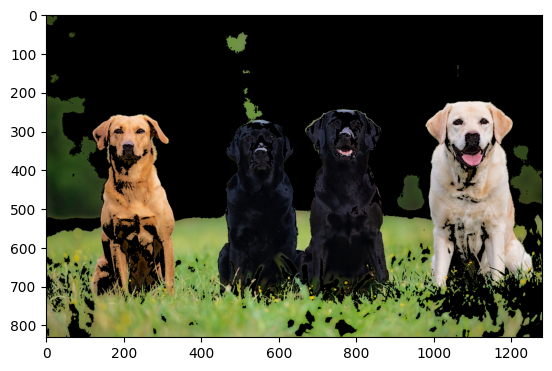

In [21]:
masked_img = np.copy(img)
masked_img = masked_img.reshape((-1,3))
cluster = 0
label = label.flatten()
masked_img[label == cluster, :] = [0, 0, 0]
masked_img = masked_img.reshape(img.shape)
plt.imshow(masked_img)
plt.show()

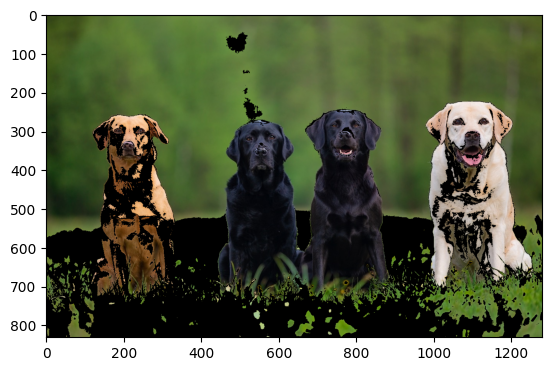

In [22]:
masked_img = np.copy(img)
masked_img = masked_img.reshape((-1,3))
cluster = 2
label = label.flatten()
masked_img[label == cluster, :] = [0, 0, 0]
masked_img = masked_img.reshape(img.shape)
plt.imshow(masked_img)
plt.show()